In [4]:
import sys
sys.path.append('/Users/mistletoe/量化金融/5-PF')
from backtest.etf_backtesting import *
backtester = Backtesting()
backtester.set_parameters(
    start_date='2023-01-01',
    end_date='2023-12-31',
    frequency_entry='1m',
    frequency_exit='60m')
df_price = backtester.load_data()

### vwap 研究

<Axes: xlabel='order_book_id,datetime'>

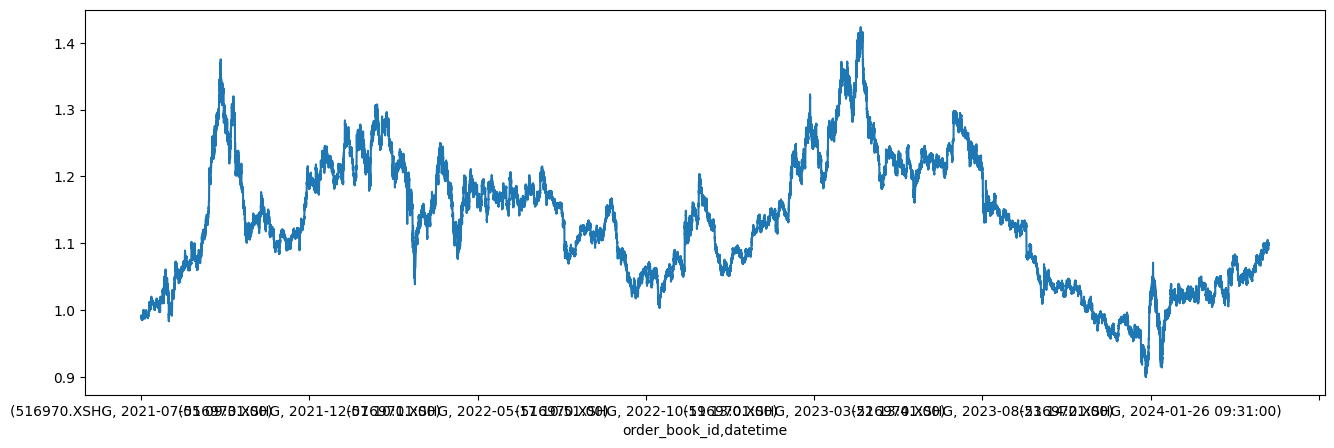

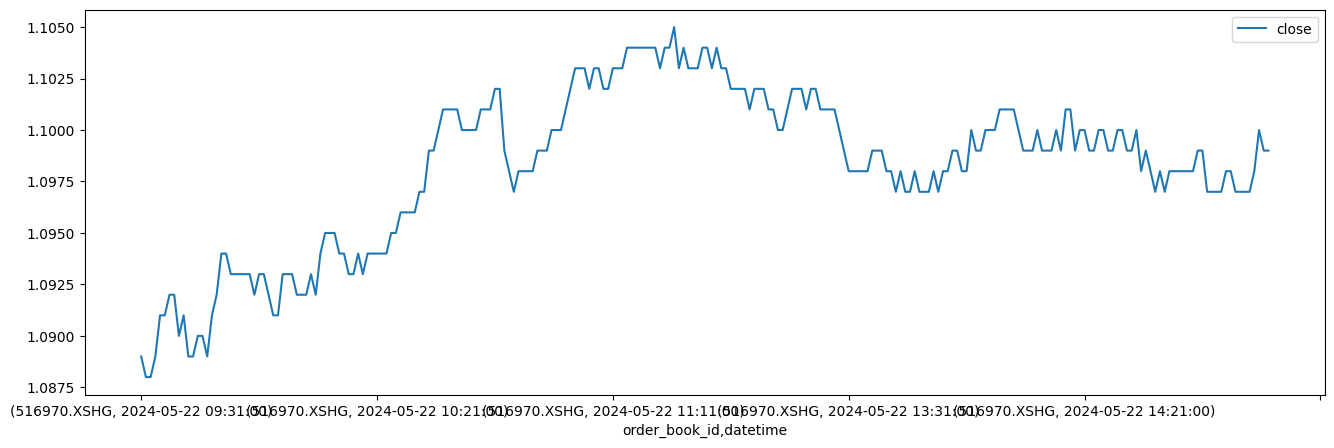

In [86]:
vwap_series = rqdatac.get_vwap('516970.XSHG', '20200522', '20240522', '1m')
price_series= rqdatac.get_price('516970.XSHG', '20240522', '20240522', '1m')[['close']]
def fill_with_previous(series):
    last_valid = None
    for idx, value in series.items():
        if value == 0 and last_valid is not None:
            series[idx] = last_valid
        elif value != 0:
            last_valid = value
    return series
vwap = fill_with_previous(vwap_series)
vwap.plot(figsize = (16,5))
price_series.plot(figsize = (16,5))

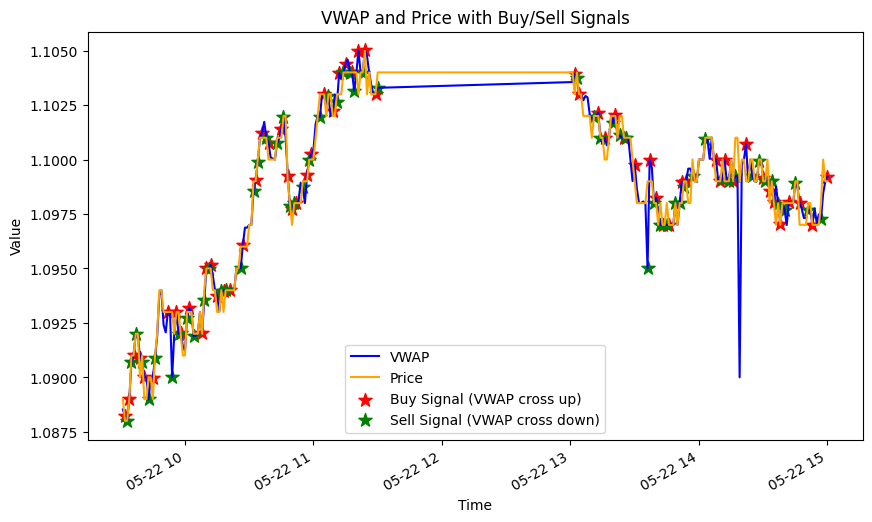

In [37]:
data = pd.DataFrame({
    "time": price_series.index.levels[1],
    "vwap": vwap_series.values,
    "price": price_series['close']
})
cross_up = (data['vwap'] > data['price']) & (data['vwap'].shift(1) <= data['price'].shift(1))
cross_down = (data['vwap'] < data['price']) & (data['vwap'].shift(1) >= data['price'].shift(1))
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['vwap'], label='VWAP', color='blue')
plt.plot(data['time'], data['price'], label='Price', color='orange')

plt.scatter(data.loc[cross_up, 'time'], data.loc[cross_up, 'vwap'], color='red', marker='*', s=100, label='Buy Signal (VWAP cross up)')
plt.scatter(data.loc[cross_down, 'time'], data.loc[cross_down, 'vwap'], color='green', marker='*', s=100, label='Sell Signal (VWAP cross down)')

# 设置图表标题和坐标轴标签
plt.title('VWAP and Price with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Value')

# 优化x轴时间格式显示并显示图例
plt.gcf().autofmt_xdate()
plt.legend()

# 显示图表
plt.show()

In [17]:
def signal_generator(series1, series2, price_series):
    data = pd.DataFrame({
        "time": series1.index.levels[1],
        "series1": series1.values,
        "series2": series2.values,
        'price_series':price_series.values
    })
    cross_up = (data['series1'] > data['series2']) & (data['series1'].shift(1) <= data['series2'].shift(1))
    cross_down = (data['series1'] < data['series2']) & (data['series1'].shift(1) >= data['series2'].shift(1))
    plt.figure(figsize=(10, 6))
    # plt.plot(data['time'], data['series1'], label='VWAP5', color='blue')
    plt.plot(data['time'], data['series2'], label='vwap_trailing_mean', color='red')
    plt.plot(data['time'], data['price_series'], label='price', color='orange')
    # plt.scatter(data.loc[cross_up, 'time'], data.loc[cross_up, 'series1'], color='red', marker='*', s=100, label='Buy Signal (VWAP cross up)')
    # plt.scatter(data.loc[cross_down, 'time'], data.loc[cross_down, 'series1'], color='green', marker='*', s=100, label='Sell Signal (VWAP cross down)')

    # 设置图表标题和坐标轴标签
    plt.title('VWAP and Price with Buy/Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # 优化x轴时间格式显示并显示图例
    plt.gcf().autofmt_xdate()
    plt.legend()

    # 显示图表
    plt.show()

* inspiration from https://mp.weixin.qq.com/s/bBPLK_L_oGMxSYRmTbKguQ

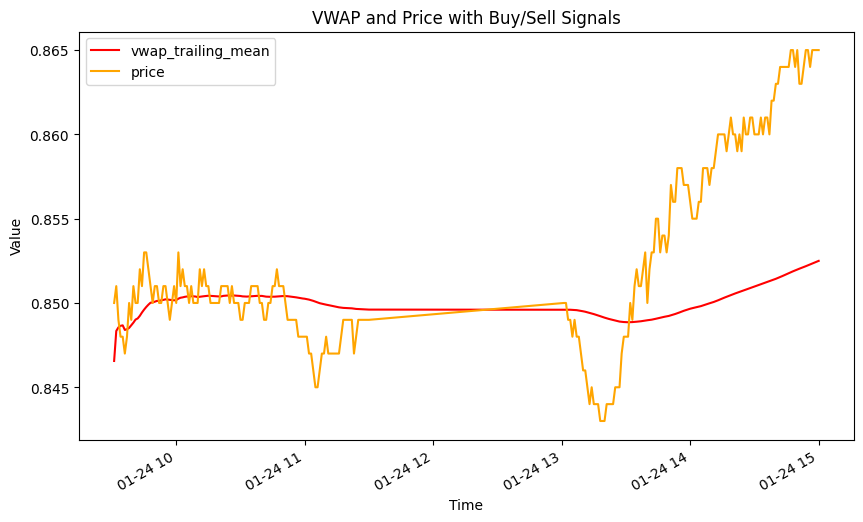

In [110]:
vwap = rqdatac.get_vwap(order_book_ids='159611.XSHE',
                        start_date = '2024-01-24',
                        end_date = '2024-01-24',
                        frequency = '1m')
vwap = fill_with_previous(vwap)
price = rqdatac.get_price(order_book_ids='159611.XSHE',
                        start_date ='2024-01-24',
                        end_date = '2024-01-24',
                        frequency = '1m')
vwap_trailing_mean = vwap.expanding().mean()
signal_generator(price['close'], vwap_trailing_mean , price['close'])

In [106]:
vwap_trailing_mean

order_book_id  datetime           
159611.XSHE    2024-05-27 09:31:00    1.011960
               2024-05-27 09:32:00    1.012008
               2024-05-27 09:33:00    1.012148
               2024-05-27 09:34:00    1.012775
               2024-05-27 09:35:00    1.013263
                                        ...   
               2024-05-27 14:56:00    1.021861
               2024-05-27 14:57:00    1.021869
               2024-05-27 14:58:00    1.021877
               2024-05-27 14:59:00    1.021885
               2024-05-27 15:00:00    1.021898
Length: 240, dtype: float64

<Axes: xlabel='order_book_id,datetime'>

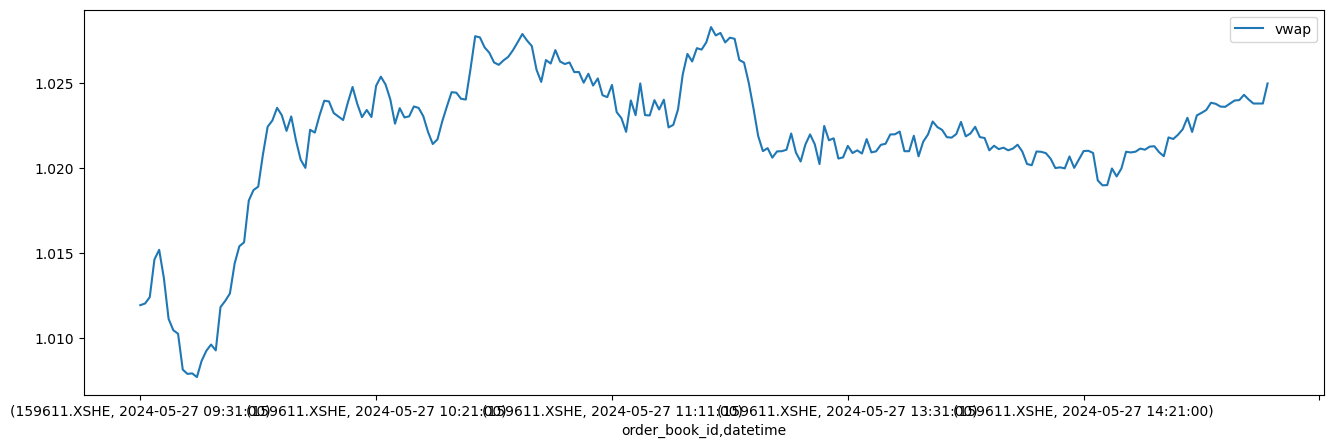

In [105]:
vwap_df = pd.DataFrame(vwap.groupby([vwap.index.get_level_values(0), vwap.index.get_level_values(1).normalize()]).apply(fill_with_previous), columns=['vwap'])
vwap_df = vwap_df.droplevel([0,1])
vwap_df.plot(figsize=(16,5))

In [ ]:
# generate trailing mean 
def fill_with_previous(series):
    last_valid = None
    for idx, value in series.items():
        if value == 0 and last_valid is not None:
            series[idx] = last_valid
        elif value != 0:
            last_valid = value
    return series

vwap = pd.DataFrame(
    rqdatac.get_vwap(
        backtester.symbol,
        '2021-01-01',
        '2023-12-31',
        frequency = '1m'
    ), columns = ['vwap']).unstack(level = 0)
vwap.columns = vwap.columns.droplevel(0)
vwap = vwap.apply(lambda col: fill_with_previous(col))

expanding_mean_df = pd.DataFrame(index=vwap.index)
# 计算每日的expanding mean
for etf in vwap.columns:
    daily_expanding_mean = vwap[etf].groupby(pd.Grouper(freq='D')).expanding().mean()
    daily_expanding_mean = daily_expanding_mean.reset_index(level=0, drop=True)
    expanding_mean_df[etf] = daily_expanding_mean
expanding_mean_df.to_csv('vwap_trailing_mean.csv')

#### 多重均线

In [70]:
price = rqdatac.get_price('159611.XSHE', start_date='2020-01-01', end_date='2023-12-31', frequency='1d')[['close']]
def calc_ma_diff(price, interval1, interval2):
    return price.rolling(interval1, min_periods=1).mean() - price.rolling(interval2, min_periods=1).mean()
ma_8_16 = calc_ma_diff(price, 8, 16)
ma_16_64 = calc_ma_diff(price, 16, 64)
ma_32_128 = calc_ma_diff(price, 32, 128)
ma_64_256 = calc_ma_diff(price, 64, 256)

In [74]:
std = price.std()
ma_multiple = (ma_8_16 + ma_16_64 + ma_32_128 + ma_64_256) / std / 4

In [78]:
ma_multiple

close
order_book_id date                
159611.XSHE   2022-01-07  0.000000
              2022-01-10  0.000000
              2022-01-11  0.000000
              2022-01-12  0.000000
              2022-01-13  0.000000
...                            ...
              2023-12-25 -0.362113
              2023-12-26 -0.372040
              2023-12-27 -0.362247
              2023-12-28 -0.355469
              2023-12-29 -0.344235

[481 rows x 1 columns]

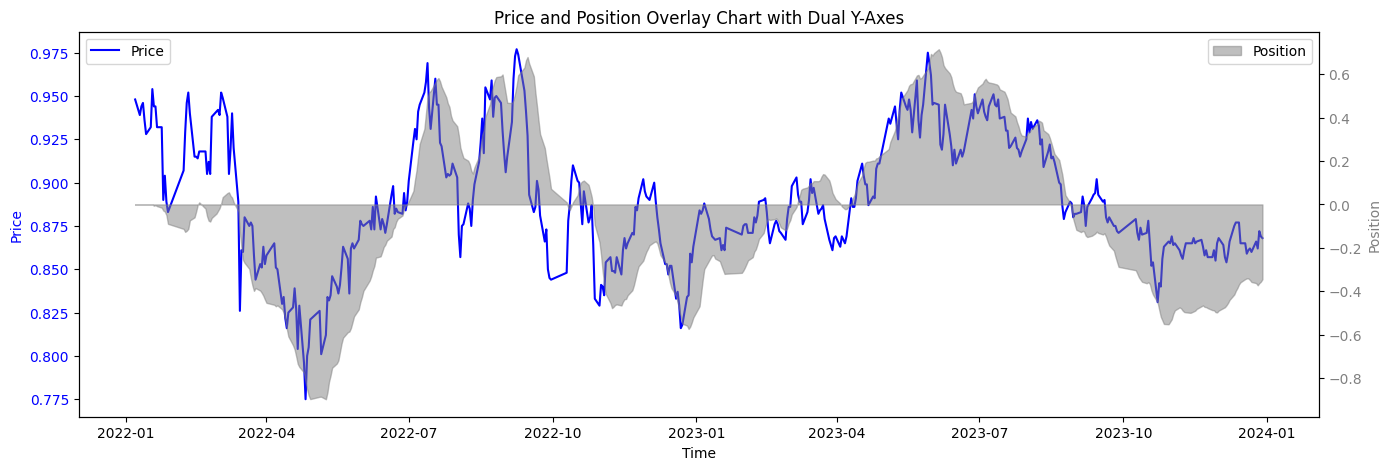

In [85]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(ma_multiple.index.levels[1], price['close'], label='Price', color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Price', color='blue')
ax.tick_params(axis='y', labelcolor='blue')
ax2 = ax.twinx()
ax2.fill_between(ma_multiple.index.levels[1], 0, ma_multiple['close'], color='grey', alpha=0.5, label='Position')
ax2.set_ylabel('Position', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Price and Position Overlay Chart with Dual Y-Axes')
plt.show()

### 开盘30min买入

In [38]:
df = df_price['159611.XSHE']
def calculate_open_to_close_higher_than_1001_ratio(df):
    df_first_30 = df.between_time(start_time='09:30', end_time='10:00')
    df_1001 = df.at_time('10:01')
    df_close = df.at_time('15:00')
    open_prices = df_first_30.groupby(df_first_30.index.date).first()
    end_prices_30 = df_first_30.groupby(df_first_30.index.date).last()
    rising_in_first_30 = (end_prices_30 - open_prices) > 0

    price_at_1001 = df_1001.groupby(df_1001.index.date).first()
    close_prices = df_close.groupby(df_close.index.date).last()
    higher_than_1001 = (close_prices - price_at_1001) > 0
    ratio = (rising_in_first_30 & higher_than_1001).sum() / rising_in_first_30.sum()
    return ratio

# 假设df是您的DataFrame
ratio = calculate_open_to_close_higher_than_1001_ratio(df)
print("开盘前三十分钟上涨的股票,最后收盘价比10:01价格高的比例:", ratio)

开盘前三十分钟上涨的股票,最后收盘价比10:01价格高的比例: 0.4827586206896552


In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression
df = df_price['159611.XSHE']
def calculate_slope(df):
    times = np.array(range(df.shape[0])).reshape(-1, 1)
    model = LinearRegression()
    model.fit(times, df.values)
    return model.coef_[0]

def calculate_open_to_close_higher_than_1001_ratio(df):
    df_first_30 = df.between_time(start_time='09:30', end_time='10:00')
    df_1001 = df.at_time('10:01')
    df_close = df.at_time('15:00')
    slopes = df_first_30.groupby(df_first_30.index.date).apply(calculate_slope)
    rising_slope_in_first_30 = slopes > 0
    print(rising_slope_in_first_30)
    price_at_1001 = df_1001.groupby(df_1001.index.date).first()
    
    close_prices = df_close.groupby(df_close.index.date).last()
    print(close_prices)
    higher_than_1001 = (close_prices - price_at_1001) > 0

    ratio = (rising_slope_in_first_30 & higher_than_1001).sum() / rising_slope_in_first_30.sum()
    return ratio
ratio = calculate_open_to_close_higher_than_1001_ratio(df)
print("开盘前三十分钟收盘价斜率向上的股票,最后收盘价比10:01价格高的比例:", ratio)

2023-01-03     True
2023-01-04    False
2023-01-05     True
2023-01-06     True
2023-01-09    False
              ...  
2023-12-25    False
2023-12-26     True
2023-12-27    False
2023-12-28    False
2023-12-29     True
Name: 159611.XSHE, Length: 242, dtype: bool
2023-01-03    0.884
2023-01-04    0.882
2023-01-05    0.884
2023-01-06    0.888
2023-01-09    0.879
              ...  
2023-12-25    0.866
2023-12-26    0.862
2023-12-27    0.872
2023-12-28    0.869
2023-12-29    0.868
Name: 159611.XSHE, Length: 242, dtype: float64
开盘前三十分钟收盘价斜率向上的股票,最后收盘价比10:01价格高的比例: 0.4661016949152542


In [32]:
etf_dict = {}
for etf in df_price.columns:
    etf_dict[etf] = calculate_open_to_close_higher_than_1001_ratio(df_price[etf])
etf_dict  

{'159507.XSHE': 0.5283018867924528,
 '159611.XSHE': 0.4827586206896552,
 '159619.XSHE': 0.4375,
 '159766.XSHE': 0.47115384615384615,
 '159825.XSHE': 0.5217391304347826,
 '159852.XSHE': 0.46956521739130436,
 '159869.XSHE': 0.5573770491803278,
 '159870.XSHE': 0.4838709677419355,
 '159928.XSHE': 0.46601941747572817,
 '159930.XSHE': 0.42342342342342343,
 '159996.XSHE': 0.5130434782608696,
 '512010.XSHG': 0.44680851063829785,
 '512170.XSHG': 0.4631578947368421,
 '512200.XSHG': 0.45544554455445546,
 '512400.XSHG': 0.45454545454545453,
 '512480.XSHG': 0.48514851485148514,
 '512660.XSHG': 0.45535714285714285,
 '512800.XSHG': 0.43243243243243246,
 '512880.XSHG': 0.4473684210526316,
 '512980.XSHG': 0.5645161290322581,
 '513050.XSHG': 0.45,
 '515030.XSHG': 0.4230769230769231,
 '515790.XSHG': 0.45161290322580644,
 '515880.XSHG': 0.44715447154471544,
 '516110.XSHG': 0.49074074074074076,
 '561320.XSHG': 0.411214953271028}

In [51]:
df_price.mean()['159507.XSHE']

0.9116854807692307

In [3]:
import pandas as pd
pd.to_datetime('202201011000').hour

10

In [55]:
import pandas as pd
import numpy as np

def calculate_er(df):
    daily_price_changes = df.diff().abs()
    daily_total_change = daily_price_changes.sum(axis=0)
    net_price_change = df.iloc[-1] - df.iloc[0]
    net_price_change_abs = net_price_change.abs()
    er = net_price_change_abs / daily_total_change
    return er

df = df_price.copy()
grouped = df.groupby(df.index.date)
er_df = pd.DataFrame()

for name, group in grouped:
    er = calculate_er(group)
    er_df = pd.concat([er_df, er.to_frame(name).T])
er_df.columns = df.columns
er_df

order_book_id,159507.XSHE,159611.XSHE,159619.XSHE,159766.XSHE,159825.XSHE,159852.XSHE,159869.XSHE,159870.XSHE,159928.XSHE,159930.XSHE,...,512660.XSHG,512800.XSHG,512880.XSHG,512980.XSHG,513050.XSHG,515030.XSHG,515790.XSHG,515880.XSHG,516110.XSHG,561320.XSHG
2023-01-03,NaN,0.185841,0.131313,0.067416,0.017857,0.214660,0.166667,0.087379,0.094891,0.116667,...,0.163399,0.080645,0.057971,0.119403,0.107981,0.106870,0.096296,0.200000,0.134752,0.011236
2023-01-04,NaN,0.009174,0.061224,0.097561,0.008696,0.006897,0.115152,0.034483,0.018405,0.089431,...,0.048780,0.148936,0.033898,0.050000,0.187166,0.115789,0.125000,0.008850,0.025000,0.061728
2023-01-05,NaN,0.009709,0.014493,0.102804,0.054945,0.055556,0.018405,0.087379,0.160920,0.029126,...,0.057971,0.022901,0.068493,0.041096,0.061069,0.179283,0.084444,0.060870,0.074830,0.106383
2023-01-06,NaN,0.000000,0.013699,0.103448,0.040000,0.000000,0.047619,0.102362,0.030303,0.103448,...,0.024000,0.029412,0.033333,0.089655,0.077586,0.101045,0.148437,0.052632,0.094118,0.065217
2023-01-09,NaN,0.080292,0.041096,0.066667,0.067797,0.056000,0.046154,0.018182,0.057592,0.015385,...,0.106061,0.007194,0.071895,0.053571,0.057778,0.032558,0.051793,0.009174,0.010753,0.035294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.058824,0.065421,0.147059,0.009009,0.052632,0.049505,0.033846,0.000000,0.057692,0.250000,...,0.026178,0.023256,0.038168,0.015228,0.067797,0.017751,0.000000,0.016949,0.054264,0.142857
2023-12-26,0.123288,0.010101,0.048780,0.070175,0.032258,0.094340,0.070922,0.011765,0.027027,0.142857,...,0.029940,0.027523,0.068702,0.060606,0.027523,0.017751,0.020690,0.083333,0.030769,0.363636
2023-12-27,0.037037,0.069307,0.037975,0.049505,0.115044,0.008696,0.085938,0.020833,0.050000,0.142857,...,0.013158,0.052632,0.040000,0.080745,0.000000,0.045977,0.018182,0.012658,0.016129,0.076923
2023-12-28,0.350000,0.026549,0.160000,0.239669,0.053571,0.208633,0.074510,0.158879,0.169014,0.088757,...,0.095890,0.079365,0.141026,0.086705,0.161765,0.242798,0.290837,0.202247,0.097143,0.240000


In [63]:
er_df.describe().idxmin(axis=1)

count    159507.XSHE
mean     512010.XSHG
std      512010.XSHG
min      159507.XSHE
25%      512170.XSHG
50%      512010.XSHG
75%      512010.XSHG
max      512010.XSHG
dtype: object

In [4]:
er_df.describe().loc['mean']

NameError: name 'er_df' is not defined